# ***0. Data Loading***

Import NB15 dataset on your Google Drive then run this cell

To-do:
- [x] Verify pandas.DataFrame = polars.DataFrame with no floating value difference
- [x] Verify polars is faster than pandas in reading csv, around 70-110ms difference

In [1]:
############################################################
#put your code for reading the csv data here
############################################################
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

import polars as pl
def polar_read_csv(csv_train, csv_val, csv_test):
    """
    Args:
        csv_train (str): name of train set csv file
        csv_val (str): name of val set csv file
        csv_test (str): name of test set csv file

    Output:
        read train, val, test sets in DataFrame format
    """
    df_train = pl.read_csv(csv_train)
    df_val = pl.read_csv(csv_val)
    df_test = pl.read_csv(csv_test)

    return df_train, df_val, df_test

polar_read_csv("UNSWNB15_training_coursework.csv", "UNSWNB15_testing1_coursework.csv", "UNSWNB15_testing2_coursework_no_label.csv")

Mounted at /content/drive
/content/drive/MyDrive


(shape: (20_000, 44)
 ┌───────┬──────────┬───────┬─────────┬───┬────────────┬────────────┬─────────────────┬───────┐
 │ id    ┆ dur      ┆ proto ┆ service ┆ … ┆ ct_src_ltm ┆ ct_srv_dst ┆ is_sm_ips_ports ┆ label │
 │ ---   ┆ ---      ┆ ---   ┆ ---     ┆   ┆ ---        ┆ ---        ┆ ---             ┆ ---   │
 │ i64   ┆ f64      ┆ str   ┆ str     ┆   ┆ i64        ┆ i64        ┆ i64             ┆ i64   │
 ╞═══════╪══════════╪═══════╪═════════╪═══╪════════════╪════════════╪═════════════════╪═══════╡
 │ 1     ┆ 0.000003 ┆ unas  ┆ -       ┆ … ┆ 8          ┆ 11         ┆ 0               ┆ 1     │
 │ 2     ┆ 0.885807 ┆ tcp   ┆ ftp     ┆ … ┆ 5          ┆ 1          ┆ 0               ┆ 0     │
 │ 3     ┆ 0.538781 ┆ tcp   ┆ http    ┆ … ┆ 2          ┆ 6          ┆ 0               ┆ 0     │
 │ 4     ┆ 0.000008 ┆ udp   ┆ dns     ┆ … ┆ 27         ┆ 34         ┆ 0               ┆ 1     │
 │ 5     ┆ 0.448734 ┆ tcp   ┆ ftp     ┆ … ┆ 1          ┆ 1          ┆ 0               ┆ 1     │
 │ …     ┆ …       

# ***1. Data Pre-Processing (Task 1)***

TO-DO:
- [x] Convert DataFrame to np.float32
- [x] Sanity check if min-max rescaling will squash small number. Observation: np.float32 will pick up the difference in (small_number+1)/big_number, but not when small_number/(big_number+1). Looking at column feature contain big numbers like dur, sload, dload, rate: their value vary greater than 1000 between different samples. This is something np.float32 can pick up. Last but not least, this tells us that we shoudl add noise to dataset after normalisation, not before
- [x] Sanity check fuse rescale-normalise == rescale first then normalise

In [2]:
############################################################
#put your code for data preprocessing here
############################################################

import polars as pl
import numpy as np

class NIDdataset():
    def __init__(
        self,
        train_file,
        val_file,
        test_file
    ):
        assert train_file.endswith(".csv"), print("train dataset should be either .csv in this project")
        assert val_file.endswith(".csv"), print("val dataset should be either .csv in this project")
        assert test_file.endswith(".csv"), print("test dataset should be either .csv in this project")

        if train_file.endswith(".csv") and val_file.endswith(".csv") and test_file.endswith(".csv"):
            train_df_encoded, val_df_encoded, test_df_encoded = self.encode_category_attribute(train_file, val_file, test_file, ["proto", "service", "state"])
            train_arr = train_df_encoded.to_numpy().astype(np.float32)
            val_arr = val_df_encoded.to_numpy().astype(np.float32)
            test_arr = test_df_encoded.to_numpy().astype(np.float32)

            train_features = train_arr[:, 1:-1]
            val_features = val_arr[:, 1:-1]
            test_features = test_arr[:, 1:]

            self.get_mean_std_after_rescaled(train_features)

        self.train_set = np.concatenate([self._transform(train_features), train_arr[:, -1].reshape(-1, 1)], axis=1)
        self.val_set = np.concatenate([self._transform(val_features), val_arr[:, -1].reshape(-1, 1)], axis=1)
        self.test_set = self._transform(test_features)

    def _transform(self, input: np.ndarray):
        processed_input = self.fused_rescale_normalise(input)
        return processed_input

    def encode_category_attribute(self, csv_train, csv_val, csv_test, attribute_list):
        """
        Args:
            csv_train (str): train set as .csv
            csv_val (str): val set as .csv
            csv_test (str): test set as .csv

        Return:
            encoded version of train set, val set, test set as polars.DataFrame using encoding dictionary for train set
        """
        df_train, df_val, df_test = polar_read_csv(csv_train, csv_val, csv_test)

        attribute_dict = {}
        for attribute in attribute_list:
            if attribute in df_train.columns:
                unique_vals = (df_train.select(attribute).drop_nulls().unique().to_series().to_list())
                attribute_dict[attribute] = {val: idx for idx, val in enumerate(unique_vals)}
            else:
                print(f"Warning: '{attribute}' not found in training CSV.")

        def apply_encoding(df, attribute_dict):
            for attribute, val_to_idx in attribute_dict.items():
                if attribute in df.columns:
                    df = df.with_columns(pl.col(attribute).replace(val_to_idx).alias(attribute))
            return df
        df_train_encoded = apply_encoding(df_train, attribute_dict)
        df_val_encoded = apply_encoding(df_val, attribute_dict)
        df_val_encoded = df_val_encoded.filter(pl.col("state") != "RST")
        df_test_encoded = apply_encoding(df_test, attribute_dict)

        return df_train_encoded, df_val_encoded, df_test_encoded

    def get_mean_std_after_rescaled(self, x: np.ndarray):
        scale = np.max(x)
        x_rescaled = x/scale
        # usually we get mean, std per channel. But nb15 doesn't channel so we get 1 mean, std over anything to not destroy local inductive bias in train_features
        self.train_mean = np.mean(x_rescaled, axis=(0,1), keepdims=True)
        self.train_std = np.std(x_rescaled, axis=(0,1), keepdims=True)

    def fused_rescale_normalise(self, x: np.ndarray):
        mean = self.train_mean.copy()
        std = self.train_std.copy()
        scaling_factor = np.max(x)
        return (x - mean*scaling_factor) / (std*scaling_factor)

nb15_dataset = NIDdataset("UNSWNB15_training_coursework.csv", "UNSWNB15_testing1_coursework.csv", "UNSWNB15_testing2_coursework_no_label.csv")
batch_size = 64
#print(f"Train set shape: {nb15_dataset.train_set.shape}")
#print(f"Val set shape: {nb15_dataset.val_set.shape}")
#print(f"Test set shape: {nb15_dataset.test_set.shape}")
print(nb15_dataset.train_mean)
print(nb15_dataset.train_std)
np.random.shuffle(nb15_dataset.train_set)
batches = [nb15_dataset.train_set[i:i+batch_size] for i in range(0, nb15_dataset.train_set.shape[0], batch_size)]

# Check shapes of initial 3 batches.
for idx, batch in enumerate(batches[:3]):
    labels = batch[:, -1].reshape(-1, 1)
    features = np.expand_dims(batch[:, :-1], axis=-1)
    print(f"\nBatch {idx+1} shape:", batch.shape)
    print(f"Batch {idx+1} feature shape:", features.shape)
    print(f"Batch {idx+1} label shape:", labels.shape)

[[0.01006994]]
[[0.07261028]]

Batch 1 shape: (64, 43)
Batch 1 feature shape: (64, 42, 1)
Batch 1 label shape: (64, 1)

Batch 2 shape: (64, 43)
Batch 2 feature shape: (64, 42, 1)
Batch 2 label shape: (64, 1)

Batch 3 shape: (64, 43)
Batch 3 feature shape: (64, 42, 1)
Batch 3 label shape: (64, 1)


# ***2. Model Implementation and Training (Task 2)***

TO-DO manually in numpy in order to implement MLP-Mixer:
- [x] Linear layer w/ manual backprop and init weight & bias w/ Kaiming uniform distribution
- [x] DropOut=0.1 w/ manual backprop
- [ ] Stochastic Depth={0->0.1}
- [x] LayerNorm w/ manual backprop
- [x] GeLU or Tanh w/ manual backprop
- [x] TokenMixer block
- [x] ChannelMixer block
- [x] Adam optimiser w/ β1 = 0.9, β2 = 0.999, weight decay = 0.03, lr=0.003
- [x] Binary Cross Entropy with logits
- [x] Optimiser.zero_grad()
- [ ] Gradient accumulation for more desired batch size = 4096

In [4]:
############################################################
#put your code for model implementation and training here
############################################################

import numpy as np
import math
from scipy.special import erf


# ---------- Init Linear weight and layer with Kaiming uniform distribution ----------
def calculate_gain(nonlinearity, param=None):
    # Inspired from https://github.com/pytorch/pytorch/blob/main/torch/nn/init.py#L72
    if nonlinearity in ['linear', 'conv1d', 'conv2d', 'conv3d',
                        'conv_transpose1d', 'conv_transpose2d', 'conv_transpose3d', 'sigmoid']:
        return 1.0
    elif nonlinearity == 'tanh':
        return 5.0 / 3
    elif nonlinearity == 'relu':
        return math.sqrt(2.0)
    elif nonlinearity == 'leaky_relu':
        negative_slope = 0.01 if param is None else param
        return math.sqrt(2.0 / (1 + negative_slope ** 2))
    else:
        raise ValueError("Unsupported nonlinearity {}".format(nonlinearity))


def _calculate_correct_fan(tensor, mode):
    # Inspired from _calculate_fan_in_and_fan_out: https://github.com/pytorch/pytorch/blob/main/torch/nn/init.py#L345
    # Note that pytorch uses _calculate_correct_fan as API for _calculate_fan_in_and_fan_out so I merely remove the API
    if tensor.ndim < 2:
        raise ValueError("Fan in and fan out cannot be computed for tensor with fewer than 2 dimensions")
    if mode == "fan_in":
        num_input_fmaps = tensor.shape[1]
        receptive_field_size = np.prod(tensor.shape[2:]) if tensor.ndim > 2 else 1
        return num_input_fmaps * receptive_field_size
    elif mode == "fan_out":
        num_output_fmaps = tensor.shape[0]
        receptive_field_size = np.prod(tensor.shape[2:]) if tensor.ndim > 2 else 1
        return num_output_fmaps * receptive_field_size
    else:
        raise ValueError("mode must be either 'fan_in' or 'fan_out'")


def kaiming_uniform_(tensor, a=0, mode="fan_in", nonlinearity="leaky_relu"):
    # Inspired from https://github.com/pytorch/pytorch/blob/main/torch/nn/init.py#L456
    fan = _calculate_correct_fan(tensor, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    bound = math.sqrt(3.0) * std
    tensor[:] = np.random.uniform(-bound, bound, tensor.shape).astype(np.float32)
    return tensor


class Linear:
    # Inspired from https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py#L50
    def __init__(self, in_features, out_features, bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.empty((out_features, in_features), dtype=np.float32)
        self.bias = np.empty((out_features,), dtype=np.float32) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        kaiming_uniform_(self.weight, a=math.sqrt(5), mode="fan_in", nonlinearity="leaky_relu")
        if self.bias is not None:
            fan_in = _calculate_correct_fan(self.weight, "fan_in")
            bound = 1 / math.sqrt(fan_in)
            self.bias[:] = np.random.uniform(-bound, bound, self.bias.shape).astype(np.float32)

    def forward(self, input):
        """
            input (batch_size, N, in_features)

            Returns np.ndarray (batch_size, N, out_features)
        """

        #output = np.einsum('bni,oi->bno', input, self.weight)
        #if self.bias is not None:
        #    output += self.bias.reshape(1, 1, -1)
        #return output

        # Original implementation # Observed no difference between einsum and original implementation
        return np.matmul(np.ascontiguousarray(input), self.weight.T) + (self.bias if self.bias is not None else 0)

    def backward(self, grad_output, input):
        """
            grad_output (np.ndarray): Gradient w.r.t. output with shape (B, N, out_features)
            input (np.ndarray): Original input with shape (B, N, in_features)

            Returns:
                grad_input (np.ndarray): Gradient w.r.t. input with shape (B, N, in_features)
                grad_weight (np.ndarray): Gradient w.r.t. weight with shape (out_features, in_features)
                grad_bias (np.ndarray or None): Gradient w.r.t. bias with shape (out_features,)
        """
        grad_input = np.matmul(grad_output, self.weight)
        if input.ndim == 2:
            self.grad_weight = np.einsum('bi,bj->ij', grad_output, input)
            self.grad_bias = np.sum(grad_output, axis=0) if self.bias is not None else None
        elif input.ndim == 3:
            self.grad_weight = np.einsum('bnk,bnl->kl', grad_output, input)
            self.grad_bias = np.sum(grad_output, axis=(0, 1))
        # store self.grad_weight and self.grad_bias for optimiser.step later on
        return grad_input, self.grad_weight, self.grad_bias


eps = 1e-5
class LayerNorm:
    def __init__(self, dim):
        self.dim = dim
        self.weight = np.ones((dim,), dtype=np.float32)
        self.bias = np.zeros((dim,), dtype=np.float32)

    def forward(self, x):
        """
        Args:
            x: (B, N, embed_dim)
        Returns:
            out: layer-normalized activations, shape (B, T, embed_dim)
            cache: tuple of (x, self.w, mean, rstd) for backward pass.
        """
        B, T, C = x.shape
        mean = np.sum(x, axis=-1, keepdims=True) / C           # (B, T, 1)
        xshift = x - mean
        var = np.sum(xshift ** 2, axis=-1, keepdims=True) / C  # (B, T, 1)
        rstd = (var + eps) ** (-0.5)                           # (B, T, 1)
        norm = xshift * rstd
        out = norm * self.weight + self.bias
        cache = (x, self.weight, mean, rstd)
        return out, cache

    def backward(self, dout, cache):
        """
        dout: upstream gradients, shape (B, N, embed_dim)
        cache: tuple of (x, w, mean, rstd) from forward pass.
        Returns:
            dx: gradient with respect to x, shape (B, T, embed_dim)
            dw: gradient with respect to self.w, shape (embed_dim,)
            db: gradient with respect to self.b, shape (embed_dim,)
        """
        x, w, mean, rstd = cache
        norm = (x - mean) * rstd
        db = np.sum(dout, axis=(0, 1))
        dw = np.sum(dout * norm, axis=(0, 1))
        dnorm = dout * w
        dnorm_mean = np.mean(dnorm, axis=-1, keepdims=True)
        dx = dnorm - dnorm_mean - norm * np.mean(dnorm * norm, axis=-1, keepdims=True)
        dx *= rstd
        self.grad_weight = dw
        self.grad_bias = db
        return dx, dw, db


class Dropout:
    # Inspired from https://gist.github.com/nbertagnolli/35eb960d08c566523b4da599f6099b41
    # and https://github.com/pytorch/pytorch/blob/v2.6.0/torch/nn/modules/dropout.py#L35
    def __init__(self, p=0.5):
        if p < 0 or p > 1:
            raise ValueError("p must be a probability in [0, 1].")
        self.p = p
        self.training = True
        self.mask = None

    def forward(self, x):
        """
        Args:
            x (np.ndarray): Input array of any shape.

        Returns:
            np.ndarray: Output array with dropout applied.
        """
        if self.training:
            # Only generate a new mask if one hasn't been set externally.
            if self.mask is None or self.mask.shape != x.shape:
                self.mask = (np.random.rand(*x.shape) >= self.p).astype(x.dtype)
            return (x * self.mask) / (1 - self.p)
        else:
            self.mask = None
            return x

    def backward(self, grad_output):
        if self.training:
            if self.mask is None:
                raise ValueError("Must run forward pass before backward pass in training mode.")
            return (grad_output * self.mask) / (1 - self.p)
        else:
            return grad_output


class Reduce_np:
    # Practically the same as AveragePooling layer along specified axis
    def __init__(self, axis, reduction='mean'):
        self.axis = axis
        self.reduction = reduction

    def forward(self, x):
        self.last_input = x.copy()
        if self.reduction == 'mean':
            return np.mean(x, axis=self.axis)
        else:
            raise NotImplementedError()

    def backward(self, grad_output):
        shape = self.last_input.shape                         # (B, N, dim)
        scale = shape[self.axis]                              # axis = N in MLP_mixer
        grad_input = grad_output / scale
        grad_input = grad_input.reshape(grad_input.shape[0], 1, grad_input.shape[1])  # Reshape to (B, 1, dim) to broadcast along N dim
        return np.broadcast_to(grad_input, shape)             # broadcasts to (B, N, dim)


# ---------- Activation Function ----------
class GELU:
    # Inspired from https://github.com/oniani/ai/blob/main/activation/gelu.py#L4
    def __init__(self):
        self.ctx = {}

    def forward(self, input):
        cdf = 0.5 * (1 + erf(input / np.sqrt(2)))
        self.ctx['input'] = input.copy()
        self.ctx['cdf'] = cdf.copy()
        return input * cdf

    def backward(self, grad_output):
        input = self.ctx['input']
        cdf = self.ctx['cdf']
        pdf_val = 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * np.power(input, 2))
        grad_local = cdf + input * pdf_val

        return grad_output * grad_local


class Tanh:
    def __init__(self):
        self.ctx = {}

    def forward(self, input):
        output = np.tanh(input)
        self.ctx['output'] = output.copy()
        return output

    def backward(self, grad_output):
        output = self.ctx['output']
        grad_input = grad_output * (1 - output**2)
        return grad_input


# ---------- Blocks ----------
class PreNormResidual:
    # Inspired from https://github.com/lucidrains/mlp-mixer-pytorch/blob/main/mlp_mixer_pytorch/mlp_mixer_pytorch.py#L7
    def __init__(self, dim, fn):
        self.norm = LayerNorm(dim)
        self.fn = fn
        # fn=TokenMixing/ChannelMixing: both return gradients w.r.t input, linear weight & bias, both have cache

    def forward(self, x):
        norm_x, norm_cache = self.norm.forward(x)
        f_out = self.fn.forward(norm_x)
        # Store caches for backward
        self.cache = {'x': x.copy(), 'norm_cache': norm_cache, 'f_cache': self.fn.cache}
        return f_out + x

    def backward(self, d_out):
        # d_out (B, N, dim)
        d_f, f_params_grad = self.fn.backward(d_out)
        # Backprop through norm: use stored norm cache
        d_norm, norm_dw, norm_db = self.norm.backward(d_f, self.cache['norm_cache'])
        self.norm.grad_weight = norm_dw
        self.norm.grad_bias = norm_db
        d_x = d_norm + d_out

        return d_x, norm_dw, norm_db, f_params_grad


# TokenMixing operates along N dimension
class TokenMixing:
    def __init__(self, num_tokens, expansion_factor, dropout_p):
        inner_dim = int(num_tokens * expansion_factor)
        self.linear1 = Linear(num_tokens, inner_dim)
        self.activation_fn = GELU()
        # self.gelu = GELU()
        self.dropout1 = Dropout(dropout_p)
        self.linear2 = Linear(inner_dim, num_tokens)
        self.dropout2 = Dropout(dropout_p)

    def forward(self, x):
        """
        x_t = x transposed
        """
        cache = {}
        x_t = np.transpose(x, (0, 2, 1))
        cache['x_t'] = x_t.copy()
        out_l1 = self.linear1.forward(x_t)
        cache['out_l1'] = out_l1.copy()
        #out_gelu = self.gelu.forward(out_l1)
        out_activation_fn = self.activation_fn.forward(out_l1)
        # cache['out_gelu'] = out_gelu.copy()
        out_drop1 = self.dropout1.forward(out_activation_fn)
        cache['out_drop1'] = out_drop1.copy()
        out_l2 = self.linear2.forward(out_drop1)
        cache['out_l2'] = out_l2.copy()
        out_drop2 = self.dropout2.forward(out_l2)
        cache['out_drop2'] = out_drop2.copy()
        out = np.transpose(out_drop2, (0, 2, 1))
        self.cache = cache
        return out

    def backward(self, d_out):
        cache = self.cache
        d_drop2 = np.transpose(d_out, (0, 2, 1))
        d_l2 = self.dropout2.backward(d_drop2)
        d_drop1, grad_w2, grad_b2 = self.linear2.backward(d_l2, cache['out_drop1'])
        # d_gelu = self.dropout1.backward(d_drop1)
        d_activation_fn = self.dropout1.backward(d_drop1)
        # d_l1 = self.gelu.backward(d_gelu)
        d_x_t, grad_w1, grad_b1 = self.linear1.backward(self.activation_fn.backward(d_activation_fn), cache['x_t'])
        d_x = np.transpose(d_x_t, (0, 2, 1))
        self.params_grad = {'linear1': (grad_w1, grad_b1), 'linear2': (grad_w2, grad_b2)}

        # Reset cache to prevent memory leak
        cache = {}
        return d_x, self.params_grad


# ChannelMixing operates along embedding dimension
class ChannelMixing:
    def __init__(self, dim, expansion_factor, dropout_p):
        inner_dim = int(dim * expansion_factor)
        self.linear1 = Linear(dim, inner_dim)
        # self.gelu = GELU()
        self.activation_fn = GELU()
        self.dropout1 = Dropout(dropout_p)
        self.linear2 = Linear(inner_dim, dim)
        self.dropout2 = Dropout(dropout_p)

    def forward(self, x):
        cache = {}
        cache['x'] = x.copy()
        out_l1 = self.linear1.forward(x)
        cache['out_l1'] = out_l1.copy()
        # out_gelu = self.gelu.forward(out_l1)
        out_activation_fn = self.activation_fn.forward(out_l1)
        # cache['out_gelu'] = out_gelu.copy()
        out_drop1 = self.dropout1.forward(out_activation_fn)
        cache['out_drop1'] = out_drop1.copy()
        out_l2 = self.linear2.forward(out_drop1)
        cache['out_l2'] = out_l2.copy()
        out_drop2 = self.dropout2.forward(out_l2)
        #cache['out_drop2'] = out_drop2.copy()
        self.cache = cache
        return out_drop2

    def backward(self, d_out):
        cache = self.cache
        d_drop2 = self.dropout2.backward(d_out)
        d_drop1, grad_w2, grad_b2 = self.linear2.backward(d_drop2, cache['out_drop1'])
        d_activation_fn = self.dropout1.backward(d_drop1)
        # d_gelu = self.dropout1.backward(d_drop1)
        d_l1, grad_w1, grad_b1 = self.linear1.backward(self.activation_fn.backward(d_activation_fn), cache['x'])
        self.params_grad = {'linear1': (grad_w1, grad_b1), 'linear2': (grad_w2, grad_b2)}

        # Reset cache to prevent memory leak
        cache = {}
        return d_l1, self.params_grad


# ---------- Model ----------
class MLPMixer:
    def __init__(self, num_tokens, input_dim, dim, depth, num_classes,
                 expansion_factor=4, expansion_factor_token=0.5, dropout_p=0.):
        """
        Args:
            num_tokens (int): Number of tokens (N).
            input_dim (int): Input token dimension.
            dim (int): Mixer embedding dimension.
            depth (int): Number of mixer layers.
            num_classes (int): Number of classes for classification.
            expansion_factor (float): Expansion factor for token mixing.
            expansion_factor_token (float): Expansion factor for channel mixing.
            dropout_p (float): Dropout probability.
        """
        self.num_tokens = num_tokens
        self.input_dim = input_dim
        self.dim = dim
        self.depth = depth
        self.num_classes = num_classes
        self.dropout_p = dropout_p
        self.proj = Linear(input_dim, dim) if input_dim != dim else None
        self.mixer_layers = []
        for _ in range(depth):
            token_mixing = PreNormResidual(dim, TokenMixing(num_tokens, expansion_factor, dropout_p))
            channel_mixing = PreNormResidual(dim, ChannelMixing(dim, expansion_factor_token, dropout_p))
            self.mixer_layers.append((token_mixing, channel_mixing))
        self.layer_norm = LayerNorm(dim)
        self.reduce = Reduce_np(axis=1, reduction='mean')
        self.classifier = Linear(dim, num_classes)
        self.cache = {}

    def forward(self, x):
        if self.proj is not None:
            self.cache['proj_in'] = x.copy()
            x = self.proj.forward(x)
        else:
            self.cache['proj_in'] = None
        self.cache['mixer'] = []

        for token_mixing, channel_mixing in self.mixer_layers:
            mixer_cache = {}
            mixer_cache['in'] = x.copy()
            t_out = token_mixing.forward(x)
            mixer_cache['token_cache'] = token_mixing.cache
            c_out = channel_mixing.forward(t_out)
            mixer_cache['channel_cache'] = channel_mixing.cache
            self.cache['mixer'].append(mixer_cache)
            x = c_out

        self.cache['ln_in'] = x.copy()
        x_ln, ln_cache = self.layer_norm.forward(x)
        self.cache['ln_cache'] = ln_cache
        self.cache['reduce_in'] = x_ln.copy()
        x_red = self.reduce.forward(x_ln)
        self.cache['clf_in'] = x_red.copy()
        x_cls = self.classifier.forward(x_red)
        self.cache['output'] = x_cls.copy()
        return x_cls

    def backward(self, grad_output):
        d_clf, _ , _ = self.classifier.backward(grad_output, self.cache['clf_in'])
        d_reduce = self.reduce.backward(d_clf)
        d_ln, _ , _ = self.layer_norm.backward(d_reduce, self.cache['ln_cache'])
        grad = d_ln

        for (token_mixing, channel_mixing), mixer_cache in zip(self.mixer_layers[::-1],
                                                               self.cache['mixer'][::-1]):
            grad, _, _, _ = channel_mixing.backward(grad)
            grad, _, _, _ = token_mixing.backward(grad)

        if self.proj is not None:
            grad, _ , _ = self.proj.backward(grad, self.cache['proj_in'])

        return grad


# ---------- Loss ----------
class BCEWithLogits_np:
    # Inspired from https://github.com/pytorch/pytorch/blob/c64e006fc399d528bb812ae589789d0365f3daf4/aten/src/ATen/native/Loss.cpp#L214-L259
    # binary cross-entropy loss in a more numerically stable way using log-sum-exp when integrating sigmoid ops under this class
    def __init__(self, weight=None, pos_weight=None, reduction='mean'):
        """
        Args:
            weight (np.ndarray or None): Optional weight tensor, broadcastable to input.
            pos_weight (np.ndarray or None): Optional weight for positive examples.
            reduction (str): 'mean' or 'sum'
        """
        self.weight = weight
        self.pos_weight = pos_weight
        self.reduction = reduction
        self.cache = {}

    def forward(self, input, target):
        """
        Args:
            input (np.ndarray): logits (B, 2)
            target (np.ndarray): labels (B, 2)
        Returns:
            loss (float or np.ndarray): reduced loss value if reduction is 'mean' or 'sum'; elementwise loss if reduction is 'none'.
        """
        max_val = np.maximum(-input, 0)

        if self.pos_weight is not None:
            log_weight = 1 + (self.pos_weight - 1) * target
            lse = np.log(np.exp(-max_val) + np.exp(-input - max_val))
            loss = (1 - target) * input + log_weight * (lse + max_val)
        else:
            loss = (1 - target) * input + max_val + np.log(np.exp(-max_val) + np.exp(-input - max_val))

        if self.weight is not None:
            loss = loss * self.weight

        self.cache['input'] = input.copy()
        self.cache['target'] = target.copy()

        if self.reduction == 'mean':
            return np.mean(loss)
        elif self.reduction == 'sum':
            return np.sum(loss)

    def backward(self, grad_output=1.0):
        input = self.cache['input']
        target = self.cache['target']

        # Compute sigmoid(input) in a stable way.
        sig = 1 / (1 + np.exp(-input))
        if self.pos_weight is not None:
            grad_input = (sig * (self.pos_weight * target + (1 - target)) - self.pos_weight * target)
        else:
            grad_input = sig - target

        if self.weight is not None:
            grad_input = grad_input * self.weight

        # If reduction is mean, scale the gradient by 1/numel.
        if self.reduction == 'mean':
            grad_input = grad_input * grad_output / input.size
        else:
            grad_input = grad_input * grad_output

        return grad_input


# ---------- Optimiser ----------
class ADAM_np:
    # Inspired from https://gist.github.com/aerinkim/dfe3da1000e67aced1c7d9279351cb88
    """
        Adam optimizer using NumPy, operating on a list of parameter 5-tuples:
            (p, param_attr, mod, grad, grad_attr)
        where:
        - p is the parameter array (e.g. mod.weight or mod.bias)
        - param_attr is "weight" or "bias"
        - mod is the module that holds this parameter
        - grad is the current gradient stored in mod (may be None if not computed yet)
        - grad_attr is the name of the attribute where the gradient is stored (e.g. "grad_weight")
    """
    def __init__(self, model, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        self.param_tuples = self.get_pointers_to_param_and_grad(model)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        # Create a state for each parameter
        self.state = {}
        for (p, param_attr, mod, grad, grad_attr) in self.param_tuples:
            self.state[id(p)] = {
                'step': 0,
                'exp_avg': np.zeros_like(p),
                'exp_avg_sq': np.zeros_like(p)
            }

    def step(self):
        """
        Update p in each tuple in self.param_tuples provided grad
        Also update state
        """
        for (p, param_attr, mod, grad, grad_attr) in self.param_tuples:
            # Retrieve the gradient dynamically
            grad = getattr(mod, grad_attr)
            state = self.state[id(p)]
            state['step'] += 1

            # Apply weight decay (L2 regularization)
            if self.weight_decay != 0:
                grad = grad + self.weight_decay * p

            # Update exponential moving averages.
            state['exp_avg'] = self.beta1 * state['exp_avg'] + (1 - self.beta1) * grad
            state['exp_avg_sq'] = self.beta2 * state['exp_avg_sq'] + (1 - self.beta2) * (grad * grad)
            denom = np.sqrt(state['exp_avg_sq']) + self.eps

            # Bias corrections.
            bias_correction1 = 1 / (1 - self.beta1 ** state['step'])
            bias_correction2 = 1 / (1 - self.beta2 ** state['step'])
            adapted_lr = self.lr * bias_correction1 / math.sqrt(bias_correction2)

            # Update parameter in place.
            p[:] = p - adapted_lr * (state['exp_avg'] / denom)

    def copy_updated_params(self):
        """
        Explicitly copy the updated parameter array p back to the module's parameters in place.
        This is done with in-place assignment to ensure the object identity is preserved.
        """
        for (p, param_attr, mod, grad, grad_attr) in self.param_tuples:
            if param_attr == "weight" and hasattr(mod, "weight"):
                mod.weight[...] = np.copy(p)
            elif param_attr == "bias" and hasattr(mod, "bias"):
                mod.bias[...] = np.copy(p)

    def get_pointers_to_param_and_grad(self, module, visited=None):
        """
        Recursively traverses the module hierarchy and returns this tuple in the exact order:
        (p, param_attr, module, grad, grad_attr)
        - p is np.float32 parameter, either weight or bias of linear layer or layernorm,
        - param_attr is a string that tells where to put p in optimiser.step equation
        - module is reference pointer to the module that holds this parameter
        - grad is np.float32 parameter, either grad_weight or grad_bias of linear layer or layernorm
        - grad_attr is a string that tells where to put grad in optimiser.step equation

        Skips keys that are irrelevant or duplicative (like params_grad) during recursive search
        """
        if visited is None:
            visited = set()
        tuples = []
        if id(module) in visited:
            return tuples
        visited.add(id(module))

        # --- Get reference pointers to the weight and grad_weight, or bias and grad_bias of a linear layer
        if hasattr(module, 'weight') and isinstance(module.weight, np.ndarray):
            tuples.append((getattr(module, 'weight', None),
                        "weight",
                        module,
                        getattr(module, 'grad_weight', None),
                        "grad_weight")
                        )
        if hasattr(module, 'bias') and module.bias is not None and isinstance(module.bias, np.ndarray):
            tuples.append((getattr(module, 'bias', None),
                        "bias",
                        module,
                        getattr(module, 'grad_bias', None),
                        "grad_bias")
                        )

        # ---  Get reference pointers to the weight and grad_weight, or bias and grad_bias of a layernorm
        if hasattr(module, 'norm'):
            norm_mod = module.norm
            if hasattr(norm_mod, 'weight') and isinstance(norm_mod.weight, np.ndarray):
                tuples.append((getattr(norm_mod, 'weight', None),
                            "weight",
                            norm_mod,
                            getattr(norm_mod, 'grad_weight', None),
                            "grad_weight")
                            )
            if hasattr(norm_mod, 'bias') and norm_mod.bias is not None and isinstance(norm_mod.bias, np.ndarray):
                tuples.append((getattr(norm_mod, 'bias', None),
                            "bias",
                            norm_mod,
                            getattr(norm_mod, 'grad_bias', None),
                            "grad_bias")
                            )

        # --- Recursively explore submodules stored as attributes.
        for key, value in module.__dict__.items():
            if key in {'cache', 'ctx', 'params_grad'}:
                continue
            if hasattr(value, 'forward') and callable(value.forward) and value is not module:
                tuples.extend(self.get_pointers_to_param_and_grad(value, visited))
            elif isinstance(value, (list, tuple)):
                for item in value:
                    if hasattr(item, 'forward') and callable(item.forward):
                        tuples.extend(self.get_pointers_to_param_and_grad(item, visited))
                    elif isinstance(item, (list, tuple)):
                        for subitem in item:
                            if hasattr(subitem, 'forward') and callable(subitem.forward):
                                tuples.extend(self.get_pointers_to_param_and_grad(subitem, visited))

        self.param_tuples = tuples
        return tuples

    def refresh_grad_per_backprop(self, model):
        self.param_tuples = self.get_pointers_to_param_and_grad(model)


# ---------- Optimiser.zero_grad() ----------
def clear_auxiliary(module):
    """
    Recursively clears auxiliary attributes from the module and its submodules.
    This includes attributes with keys 'cache', 'ctx', 'params_grad', and 'mask'.

    For each key:
      - If its value is a dict, it is set to {}.
      - Otherwise, it is set to None.
    """
    aux_keys = ('cache', 'ctx', 'params_grad', 'mask')
    # Clear any auxiliary attribute on this module.
    for key in aux_keys:
        if key in module.__dict__:
            current = module.__dict__[key]
            if isinstance(current, dict):
                setattr(module, key, {})
            else:
                setattr(module, key, None)

    # Now recursively traverse submodules.
    for key, value in module.__dict__.items():
        # Skip aux keys already handled.
        if key in aux_keys:
            continue

        # If the attribute is a list or tuple, iterate through its items.
        if isinstance(value, (list, tuple)):
            for item in value:
                if isinstance(item, tuple):
                    for subitem in item:
                        if hasattr(subitem, 'forward') and callable(subitem.forward):
                            clear_auxiliary(subitem)
                elif hasattr(value, 'forward') and callable(value.forward):
                    # Unlikely: this checks if the entire list itself has a forward().
                    clear_auxiliary(value)
                elif hasattr(item, 'forward') and callable(item.forward):
                    clear_auxiliary(item)
        # If the attribute is a submodule (has callable forward), recurse.
        elif hasattr(value, 'forward') and callable(value.forward) and value is not module:
            clear_auxiliary(value)


# ---------- After training ----------
def save_model_and_optimiser(model, optimiser, filename="model_optim_state.npy"):
    """
    Save model parameters and optimizer state to a .npy file.
    The final dictionary has the form:

        {
           "model_state": { key: parameter_array, ... },
           "optimizer_state": optimizer.state
        }

    Args:
        model: Your MLPMixer instance.
        optimizer: Your ADAM_np instance.
        filename: The file name to save the state (default: "model_optim_state.npy").
    """
    param_tuples = optimiser.get_pointers_to_param_and_grad(model)

    model_state = {}
    # Create a unique key for each parameter.
    for (p, param_attr, mod, grad, grad_attr) in param_tuples:
        key = f"{mod.__class__.__name__}_{param_attr}_{id(p)}"
        model_state[key] = p.copy()

    optimiser_state = optimiser.state.copy()

    state = {
        "model_state": model_state,
        "optimizer_state": optimiser_state
    }

    # Save to a .npy file (when loading, use allow_pickle=True).
    np.save(filename, state)
    print(f"Model and optimizer state saved to {filename}")


# ---------- Model, optimiser, loss instantiation ----------
model = MLPMixer(num_tokens=42, input_dim=1, dim=48, depth=10, num_classes=1, dropout_p=0.1)
loss_fn_np = BCEWithLogits_np(reduction='mean')
optimiser_np = ADAM_np(model, lr=0.01, weight_decay=0)
# print(optimiser_np.param_tuples)


# ---------- Training loop ----------
batch_size = 64
num_epochs = 34
train_losses = []
val_losses = []
train_iter = 0
val_iter = 0

import pdb
for epoch in range(num_epochs):
    np.random.shuffle(nb15_dataset.train_set)
    batches = [nb15_dataset.train_set[i:i+batch_size] for i in range(0, nb15_dataset.train_set.shape[0], batch_size)]
    print("\nEpoch:", epoch)

    total_train_loss_per_epoch = 0.0
    for batch in batches:
        labels = batch[:, -1].reshape(-1, 1)
        features = np.expand_dims(batch[:, :-1], axis=-1)
        logits = model.forward(features)

        batch_train_loss = loss_fn_np.forward(logits, labels)

        grad_logits = loss_fn_np.backward()
        _ = model.backward(grad_logits)

        #before_step_mixer_linear = np.copy(model.mixer_layers[0][0].fn.linear1.weight)
        optimiser_np.refresh_grad_per_backprop(model)
        #print(optimiser_np.param_tuples)
        #pdb.set_trace()
        optimiser_np.step()
        #after_step_mixer_linear = model.mixer_layers[0][0].fn.linear1.weight
        #print("Max abs diff between before and after stepping (should be a small difference):", np.max(np.abs(before_step_mixer_linear - after_step_mixer_linear)))
        optimiser_np.copy_updated_params()
        #after_step_and_copy_mixer_linear = model.mixer_layers[0][0].fn.linear1.weight
        #print("Max abs diff between before and after update and copy (should be 0):", np.max(np.abs(after_step_and_copy_mixer_linear - after_step_mixer_linear)))
        #pdb.set_trace()

        clear_auxiliary(model)
        total_train_loss_per_epoch += batch_train_loss

        train_iter += 1
        if train_iter % 50 == 0:
            print(f"Train Iteration {train_iter}, Loss: {batch_train_loss:.8f}")
    avg_train_loss_per_epoch = total_train_loss_per_epoch / len(batches)
    train_losses.append(avg_train_loss_per_epoch)

    total_val_loss_per_epoch = 0.0
    val_batches = [nb15_dataset.val_set[i:i+batch_size] for i in range(0, nb15_dataset.val_set.shape[0], batch_size)]
    for val_batch in val_batches:
        labels = val_batch[:, -1].reshape(-1, 1)
        features = np.expand_dims(val_batch[:, :-1], axis=-1)
        logits = model.forward(features)

        batch_val_loss = loss_fn_np.forward(logits, labels)

        total_val_loss_per_epoch += batch_val_loss

        val_iter += 1
        if val_iter % 50 == 0:
            print(f"Val Iteration {val_iter}, Loss: {batch_val_loss:.8f}")

    avg_val_loss_per_epoch = total_val_loss_per_epoch / len(val_batches)
    val_losses.append(avg_val_loss_per_epoch)

print("Average loss:", np.mean(train_losses))
save_model_and_optimiser(model, optimiser_np)


Epoch: 0
Train Iteration 50, Loss: 0.62727369
Train Iteration 100, Loss: 0.55524590
Train Iteration 150, Loss: 0.47007962
Train Iteration 200, Loss: 0.47432268
Train Iteration 250, Loss: 0.58601827
Train Iteration 300, Loss: 0.47609859
Val Iteration 50, Loss: 0.54719018

Epoch: 1
Train Iteration 350, Loss: 0.54614159
Train Iteration 400, Loss: 0.54497079
Train Iteration 450, Loss: 0.57369857
Train Iteration 500, Loss: 0.45389511
Train Iteration 550, Loss: 0.50073429
Train Iteration 600, Loss: 0.51342104
Val Iteration 100, Loss: 0.62025088

Epoch: 2
Train Iteration 650, Loss: 0.54641933
Train Iteration 700, Loss: 0.58364668
Train Iteration 750, Loss: 0.56350443
Train Iteration 800, Loss: 0.48119427
Train Iteration 850, Loss: 0.47673279
Train Iteration 900, Loss: 0.55519327
Val Iteration 150, Loss: 0.46794233

Epoch: 3
Train Iteration 950, Loss: 0.58025893
Train Iteration 1000, Loss: 0.61781445
Train Iteration 1050, Loss: 0.62832171
Train Iteration 1100, Loss: 0.56682327
Train Iteration

In [112]:
# print(optimiser_np.state)

In [6]:
# print(optimiser_np.param_tuples)

In [23]:
#clear_auxiliary(model)

In [24]:
#import gc
#gc.collect()

274

# ***3. Model Performance Evaluation (Task 3)***

Loaded model and optimizer state from 'model_optim_state.npy'
Precision: 0.9592
Recall: 0.6120
F1 Score: 0.7473
Balanced Accuracy: 0.7792


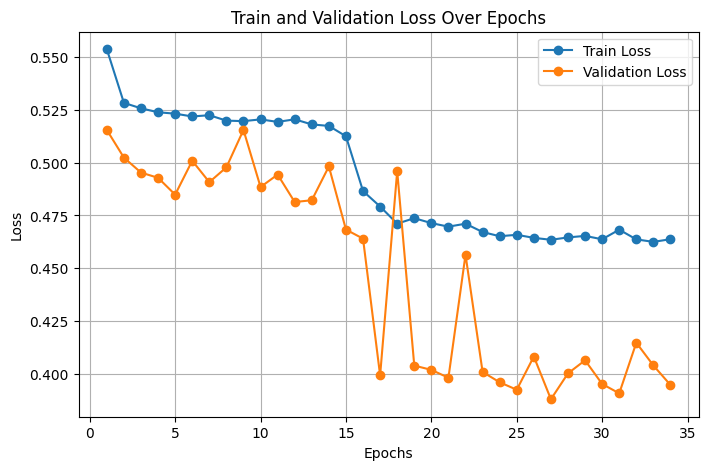

[[1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]]


In [20]:
############################################################
#put your code for model performance evaluation here
def load_model_and_optimiser(model, optimiser, filename="model_optim_state.npy"):
    """
    Load pretrained model parameters and optimizer state from a file.

    This function loads the state dictionary saved using 'save_model_and_optimiser', updates
    the model's parameters (in place) and sets the optimizer's state accordingly.

    Args:
        model: The model instance whose parameters should be updated.
        optimiser: The instance of ADAM_np managing the model parameters.
        filename: The filename of the saved state (default is "model_optim_state.npy").

    Raises:
        KeyError: If a parameter key from the model is not found in the saved state.
    """
    import numpy as np

    # Load the saved state dictionary with allow_pickle=True
    state = np.load(filename, allow_pickle=True).item()
    saved_model_state = state["model_state"]
    saved_optimiser_state = state["optimizer_state"]

    # Refresh the mapping (the same order as used when saving is assumed)
    param_tuples = optimiser.get_pointers_to_param_and_grad(model)

    # Update each parameter in the model using the saved state
    for (p, param_attr, mod, grad, grad_attr) in param_tuples:
        # Recreate the key used during saving
        key = f"{mod.__class__.__name__}_{param_attr}_{id(p)}"
        if key in saved_model_state:
            # In-place update of the parameter array
            p[...] = saved_model_state[key]
        else:
            # If key not found, it's likely there's a mismatch between model architectures
            raise KeyError(f"Parameter key '{key}' not found in saved state. "
                           "Ensure that the model architecture and the optimizer pointers "
                           "match those used when saving.")

    # Update the optimizer state (this assumes the optimizer's internal state structure remains consistent)
    optimiser.state = saved_optimiser_state.copy()

    print(f"Loaded model and optimizer state from '{filename}'")

load_model_and_optimiser(model, optimiser_np)
all_labels = []
all_predictions = []

for val_batch in val_batches:
    labels = val_batch[:, -1].reshape(-1, 1)
    features = np.expand_dims(val_batch[:, :-1], axis=-1)
    logits = model.forward(features)

    probabilities = 1 / (1 + np.exp(-logits))

    predictions = (probabilities >= 0.5).astype(int)

    all_labels.append(labels)
    all_predictions.append(predictions)

all_labels = np.concatenate(all_labels, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

TP = np.sum((all_predictions == 1) & (all_labels == 1))
FP = np.sum((all_predictions == 1) & (all_labels == 0))
TN = np.sum((all_predictions == 0) & (all_labels == 0))
FN = np.sum((all_predictions == 0) & (all_labels == 1))

precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0

recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

balanced_accuracy = (recall + specificity) / 2

# Print the results.
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {F1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
############################################################

import matplotlib.pyplot as plt
# Assuming train_losses and val_losses are lists of loss values per epoch.
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

test_features = np.expand_dims(nb15_dataset.test_set, axis=-1)
test_logits = model.forward(test_features)
test_probabilities = 1 / (1 + np.exp(-test_logits))
test_predictions = (test_probabilities >= 0.5).astype(int)
print(test_predictions)

# ***4. Performance Evaluation***

**Please report the classification accuracy your model achieved on data samples in the testing set 1 below (in percentage)**

95.92%



**Please provide the predicted class labels of the data samples in the testing set 1 below (0 or 1)**

| **Sample ID** |**Predicted Label** |
| --- | --- |
| 1 | 1 |
| 2 | 0 |
| 3 | 1 |
| 4 | 1 |
| 5 | 0  |
| 6 | 0  |
| 7 | 0  |
| 8 | 0  |
| 9 | 0  |
| 10 |0   |
| 11 |0   |
| 12 |0   |
| 13 |1   |
| 14 |1   |
| 15 |0   |
| 16 |0   |
| 17 |1   |
| 18 |1   |
| 19 |0   |
| 20 |0   |
| 21 |0   |
| 22 |1   |
| 23 |0   |
| 24 |0   |
| 25 |1   |